## Introduction

We saw some monthly auto-correlation in volatility [here](/posts/autocorrelation-volatility). Let us try to create a strategy out of it and see if it holds an edge. Our strategy is to hold the stock when the volatility is low.

## Strategy

1. Calculate the monthly volatility of the stock
2. Calculate the 12-period rolling monthly volatility
3. If the present month volatility is less than the rolling volatilty, hold the stock

Volatility is simply the standard deviation of the daily returns

<!-- TEASER_END -->


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


In [2]:
df = pd.read_csv('/home/pi/data/sp500.csv', parse_dates=['Date']).rename(
columns = lambda x:x.lower()).sort_values(by='date').set_index('date')
df['ret'] = df.close.pct_change()

The following two functions 
 * generate the returns and then 
 * plots the cumulative returns based on each signal
 
signal 1 means that last month volatility is more than the moving average of the 12 month volatility while signal 0 indicates the volatility is less than the average. All denotes holding the stock all the period. So,
 * 1 denotes more volatility
 * 0 denotes less volatility

In [3]:
def generate_returns_table(data, freq='M'):
    """
    Generate the returns dataframe
    data
        Daily data
    freq
        frequency as pandas string
    """
    monthly_returns = data.resample(freq).close.ohlc().close.pct_change()
    monthly_volatility = data.resample(freq).ret.std()
    df2 = pd.DataFrame({
        'returns': monthly_returns,
        'volatility': monthly_volatility
    }).dropna()
    df2['rolling_vol'] = df2.volatility.rolling(12).median()
    df2['signal'] = df2.eval('(volatility>rolling_vol)+0').shift(1)
    return df2

def plot_strategy(data, column='signal'):
    """
    Plot the returns based on signal
    data
        dataframe with returns
    column
        column containing the signal
    """
    collect = []
    d = data.copy()
    d['name'] = 'all'
    d['cum_returns'] = d.eval('1+returns').cumprod()    
    collect.append(d)
    grouped = d.groupby(column)
    for name, group in grouped:
        group['name'] = name
        group['cum_returns'] = group.eval('1+returns').cumprod()
        collect.append(group)
    tmp = pd.concat(collect).reset_index()
    return sns.lineplot(x='date', y='cum_returns', hue='name', data=tmp)

,count,mean,std,min,25%,50%,75%,max
signal,,,,,,,,
0.0,148.0,0.007405,0.035204,-0.085962,-0.015188,0.011449,0.028690,0.107546
1.0,114.0,0.002998,0.052159,-0.169425,-0.025201,0.009228,0.035504,0.126844


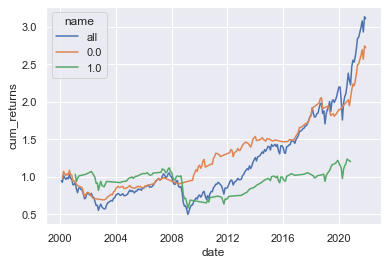

In [4]:
strategy = generate_returns_table(df)
plot_strategy(strategy)
strategy.groupby('signal').returns.describe()

There seems to be an edge here. A signal of 0, lower volatility, generates better returns at a lesser risk. But the optimal thing to do, by looking at the cumulative returns chart, is to stay invested all the time as it gives the maximum total returns. 

Let us try doing this on a quarterly basis. Instead of calculating the monthly volatility, calculate the quarterly volatility and apply the same algorithm

,count,mean,std,min,25%,50%,75%,max
signal,,,,,,,,
0.0,53.0,0.001043,0.076472,-0.200011,-0.023018,0.012990,0.054221,0.116419
1.0,34.0,0.039976,0.087841,-0.225582,0.005207,0.049272,0.101734,0.199529


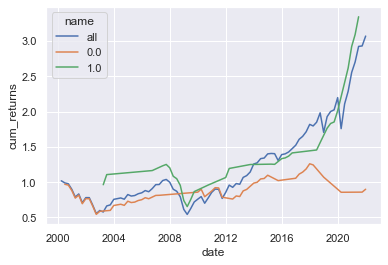

In [5]:
strategy = generate_returns_table(df, freq='Q')
plot_strategy(strategy)
strategy.groupby('signal').returns.describe()

From the cumulative returns chart, it looks that investing when the signal is 1, during higher volatility, looks better than staying invested all the time. This is in contrast with what is observed when we used monthly frequency, which needs to be investigated further.

You can try different frequencies and different instruments by cloning this notebook

<div class="alert alert-info">
    Transaction costs and slippage not included. Also the result doesn't resemble an exact portfolio.
    </div>

<div class="alert alert-warning">
    I have not tested for statistical significance for these results, which is important.
    These are only raw results
    </div>